## Limpieza de la base de datos

In [1]:
#En este bloque se realiza la limpieza y transformación de la base de datos para su posterior uso

#Importacion de las bibliotecas necesarias
import pandas as pd
import unicodedata
import re

#Se define esta función para normalizar los posibles caracteres especiales
def normalize_text(text):
    if pd.isnull(text):
        return text
    text = unicodedata.normalize("NFKD", text)
    text = text.lower().strip()
    return text

#Se define esta función para eliminar los digitos seguidos de un espacio y limpiar la variable "Name"
def clean_name(name):
    cleaned_name = re.sub(r'\b\d+\s+', "", name)
    return cleaned_name

#Se define esta función para eliminar los digitos seguidos de un punto y un espacio y limpiar la variable "Club"
def clean_club(club):
    #Se comprueba si el valor es Nulo o no es un string
    if pd.isnull(club) or not isinstance(club, str):
        return club
    cleaned_club = re.sub(r'\b\d+\.\s+', "", club)
    return cleaned_club

#Se define esta función para eliminar los caracteres entre "<>" que son utiles de la variable "Position"
def clean_position(position):
    if pd.isnull(position):
        return position
    cleaned_position = re.sub(r'<[^>]+>', "", position)
    return cleaned_position.strip() 
    
#Se define esta función para transformar la variable "Height" de pies a metros
def convert_height(height):
    if pd.isnull(height) or not isinstance(height, str):
        return height
    parts = height.split("'")
    if len(parts) == 2:
        feet = int(parts[0])
        inches = int(parts[1])
        meters = feet * 0.3048 + inches * 0.0254
        return round(meters, 2)
    else:
        return height

#Se define esta función para transformar la variable "Weight" de libras a kilogramos
def convert_weight(weight):
    if pd.isnull(weight) or not isinstance(weight, str):
        return weight
    if weight.endswith("lbs"):
        lbs = int(weight.replace("lbs", ""))
        kg = round(lbs * 0.453592, 2)
        return kg
    #Se verifica si el peso ya esta en kg, ya que algunos registros ya lo tenian así
    elif weight.endswith("kg"):
        #Se convierte a float si el número esta en kg
        kg = float(weight.replace("kg", ""))
        return round(kg, 2) 
    else:
        try:
            return round(float(weight), 2)
        except ValueError:
            return weight  # Devuelve el valor original si no puede convertirse

#Se define esta función para unificar la variable "Contract_date" y poner solo el año
def extract_year(contract_date):
    if pd.isnull(contract_date):
        return contract_date
    #Se verifica si el contrato contiene una fecha completa con mes y día, es decir, si no viene solo el año
    if ',' in contract_date:
        #Se extrae solo el año
        year = pd.to_datetime(contract_date).year
    else:
        #Si no, se deja como esta
        year = contract_date
    return year

#Se define esta función para estandarizar las columnas que son iguales cada año
def clean_key_columns(df):
    #Se implementan las funciones definidas anteriormente
    df["Name"] = df["Name"].apply(clean_name).apply(normalize_text)
    df["Club"] = df["Club"].apply(clean_club).apply(normalize_text)
    df["Position"] = df["Position"].apply(clean_position)
    df["Height"] = df["Height"].apply(convert_height)
    df["Weight"] = df["Weight"].apply(convert_weight)
    df["Contract Valid Until"] = df["Contract Valid Until"].apply(extract_year)
    #Se normalizan el resto de columnas
    for column in ["Nationality", "Preferred Foot"]:
        df[column] = df[column].apply(normalize_text)
    return df

#Antes de esta carga se ha hecho una pequeña limpieza de los datasets con la aplicación OpenRefine para la variable "Club"

#Se cargan los 3 datasets
data_2020 = pd.read_csv("https://raw.githubusercontent.com/Sergioferr7/TFM_Sergio_Fernandez_Villafa-ez/main/FIFA20_official_data.csv", encoding="utf-8-sig")
data_2021 = pd.read_csv("https://raw.githubusercontent.com/Sergioferr7/TFM_Sergio_Fernandez_Villafa-ez/main/FIFA21_official_data.csv", encoding="utf-8-sig")
data_2022 = pd.read_csv("https://raw.githubusercontent.com/Sergioferr7/TFM_Sergio_Fernandez_Villafa-ez/main/FIFA22_official_data.csv", encoding="utf-8-sig")

#Se aplica la limpieza sobre ellos
data_2020 = clean_key_columns(data_2020)
data_2021 = clean_key_columns(data_2021)
data_2022 = clean_key_columns(data_2022)


#Se eliminan las variables no deseadas
variables_to_drop = ["Photo", "Flag", "Club Logo", "Real Face", "Loaned From", 
                     "Release Clause", "Special", "International Reputation", "Body Type", 
                     "Jersey Number", "Joined", "Aggression", "Positioning", "Marking", 
                     "Composure", "GKHandling", "Best Position", "DefensiveAwareness"]

data_2020.drop(columns=variables_to_drop, inplace=True, errors="ignore")
data_2021.drop(columns=variables_to_drop, inplace=True, errors="ignore")
data_2022.drop(columns=variables_to_drop, inplace=True, errors="ignore")


#Se eliminan registros duplicados
data_2020 = data_2020.drop_duplicates(subset=["ID"])
data_2021 = data_2021.drop_duplicates(subset=["ID"])
data_2022 = data_2022.drop_duplicates(subset=["ID"])

#Se definen las columnas que se mantendrán constantes a pesar del año
columns_to_keep = ["ID", "Name", "Nationality", "Preferred Foot"]

#Se renombran las columnas para incluir al final un sufijo con el año al que pertenece el registro excluyendo las variables que permanecen constantes
def rename_columns(df, year, columns_to_keep):
    # Renombrar solo las columnas que no están en la lista de columnas a mantener
    return df.rename(columns={
        col: f"{col}_{year}" if col not in columns_to_keep else col for col in df.columns
    })


#Se renombran las columnas
data_2020 = rename_columns(data_2020, 2020, columns_to_keep)
data_2021 = rename_columns(data_2021, 2021, columns_to_keep)
data_2022 = rename_columns(data_2022, 2022, columns_to_keep)

#Se muestra un ejemplo
print("Ejemplo de nombre limpiado en 2020:")
print(data_2020["Name"][33])
print(data_2020["Height_2020"][33])
print(data_2020["Weight_2020"][33])

#Nos aseguramos de que data_2021 y data_2022 NO tienen columnas que deben de ser constantes
data_2021 = data_2021.drop(columns=columns_to_keep[1:], errors="ignore")
data_2022 = data_2022.drop(columns=columns_to_keep[1:], errors="ignore")

#Se transforman las columnas a numérico
data_2020["Contract Valid Until_2020"] = pd.to_numeric(data_2020["Contract Valid Until_2020"], errors="coerce")
data_2021["Contract Valid Until_2021"] = pd.to_numeric(data_2021["Contract Valid Until_2021"], errors="coerce")
data_2022["Contract Valid Until_2022"] = pd.to_numeric(data_2022["Contract Valid Until_2022"], errors="coerce")

#Se muestran los valores a eliminar de cada dataset
count_below_2020_in_data_2020 = (data_2020["Contract Valid Until_2020"] < 2020).sum()
count_below_2020_in_data_2021 = (data_2021["Contract Valid Until_2021"] < 2020).sum()
count_below_2020_in_data_2022 = (data_2022["Contract Valid Until_2022"] < 2020).sum()

print(f"Contratos antes de 2020 en el dataset de 2020: {count_below_2020_in_data_2020}")
print(f"Contratos antes de 2020 en el dataset de 2021: {count_below_2020_in_data_2021}")
print(f"Contratos antes de 2020 en el dataset de 2022: {count_below_2020_in_data_2022}")

#Solo se requieren los registros donde el jugador tenga un contrato superior a 2020 ya que es el año del que parte el estudio
data_2020 = data_2020[data_2020["Contract Valid Until_2020"] >= 2020]
data_2021 = data_2021[data_2021["Contract Valid Until_2021"] >= 2020]
data_2022 = data_2022[data_2022["Contract Valid Until_2022"] >= 2020]

#Se eliminan los caracteres de la variable "Height_2022"
data_2022["Height_2022"] = data_2022["Height_2022"].str.replace("cm", "").astype(int)
data_2022["Height_2022"] = data_2022["Height_2022"] / 100

#Se comprueba
print(data_2022["Height_2022"].head())
print(data_2021["Height_2021"].head())

#Se transforma el club "Atlético de Madrid" de 2022 al valor "Atlético Madrid" que es como viene en 2020 y 2021
data_2022["Club_2022"] = data_2022["Club_2022"].replace("Atlético de Madrid", "Atlético Madrid")

#Se unifican los valores del dataset de 2022 para el valor "al ain" y "al ain fc"
reemplazos = {"al ain fc": "al ain"}
data_2022["Club_2022"] = data_2022["Club_2022"].replace(reemplazos)

Ejemplo de nombre limpiado en 2020:
dani alves
1.73
68.04
Contratos antes de 2020 en el dataset de 2020: 1004
Contratos antes de 2020 en el dataset de 2021: 625
Contratos antes de 2020 en el dataset de 2022: 650
0    1.79
1    1.89
2    1.82
3    1.81
4    1.72
Name: Height_2022, dtype: float64
0    1.83
1    1.80
2    1.78
3    1.75
4    1.73
Name: Height_2021, dtype: float64


## Union de la base de datos tras su limpieza

In [2]:

#Se realiza la unión de las bases de datos
merged_data = pd.merge(data_2020, data_2021, on="ID", how="inner")
merged_data_final = pd.merge(merged_data, data_2022, on="ID", how="inner")

#Si existen columnas con '_2021' o '_2022' para las variables, "ID", "Name", "Nationality" o "Preferred Foot", se eliminan
for col in columns_to_keep[1:]:  # Comienza desde 1 para excluir 'ID'
    merged_data_final.drop(columns=[f"{col}_2021", f"{col}_2022"], errors="ignore", inplace=True)




## Transformación de la variable position

In [3]:
#Se crea un diccionario para mapear cada posición específica a una definición
position_mapping = {
    "ST": "DELANTERO",
    "LW": "DELANTERO",
    "CAM": "MEDIOCENTRO",
    "RCM": "MEDIOCENTRO",
    "LB": "DEFENSA",
    "LDM": "MEDIOCENTRO",
    "RF": "DELANTERO",
    "LCB": "DEFENSA",
    "SUB": "RESERVA",  
    "RW": "DELANTERO",
    "LCM": "MEDIOCENTRO",
    "CDM": "MEDIOCENTRO",
    "LS": "DELANTERO",
    "CF": "DELANTERO",
    "LM": "MEDIOCENTRO",
    "RB": "DEFENSA",
    "RDM": "MEDIOCENTRO",
    "CM": "MEDIOCENTRO",
    "RES": "RESERVA", 
    "LF": "DELANTERO",
    "RAM": "MEDIOCENTRO",
    "LWB": "DEFENSA",
    "LAM": "MEDIOCENTRO",
    "RM": "MEDIOCENTRO",
    "RCB": "DEFENSA",
    "RS": "DELANTERO",
    "RWB": "DEFENSA",
    "CB": "DEFENSA",
    "GK": "PORTERO"
}

#Se aplica el mapeo para cada columna 
merged_data_final["Def_position_2020"] = merged_data_final["Position_2020"].map(position_mapping)
merged_data_final["Def_position_2021"] = merged_data_final["Position_2021"].map(position_mapping)
merged_data_final["Def_position_2022"] = merged_data_final["Position_2022"].map(position_mapping)

#Los que son "RESERVA" no tiene sentido para el estudio se cuenta cuantos son
count_reserva_2020 = merged_data_final["Def_position_2020"].value_counts().get("RESERVA", 0)
count_reserva_2021 = merged_data_final["Def_position_2021"].value_counts().get("RESERVA", 0)
count_reserva_2022 = merged_data_final["Def_position_2022"].value_counts().get("RESERVA", 0)

print(f"Reservas en 2020: {count_reserva_2020}")
print(f"Reservas en 2021: {count_reserva_2021}")
print(f"Reservas en 2022: {count_reserva_2022}")


#Se define esta función para definir la posición que no sea RES en los registros
def seleccionar_posicion(row):
    #Se prioriza la posición que no sea "SUB" o "RES"
    for col in ["Position_2020", "Position_2021", "Position_2022"]:
        if row[col] not in ["SUB", "RES"]:
            return row[col]
    #Si todos son "SUB" o "RES", devuelve "SUB" o "RES" del año 2020
    return row["Position_2020"]

#Se ejecuta la función 
merged_data_final["POSITION"] = merged_data_final.apply(seleccionar_posicion, axis=1)

#Se eliminan los registros donde las posición sea "SUB" o "RES" en los tres años
merged_data_final = merged_data_final[~merged_data_final["POSITION"].isin(["SUB", "RES"])]

#Se eliminan las columnas de posición separadas por años
merged_data_final.drop(["Position_2020", "Position_2021", "Position_2022","Def_position_2020","Def_position_2021","Def_position_2022"], axis=1, inplace=True)

#Se eliminan los valores nulos
merged_data_final.dropna(subset=["POSITION"], inplace=True)

#Se muestra algun registro para ver su estado final
print(merged_data_final[["ID", "Name", "POSITION"]].head())

#Se aplica el mapeo para la columna transformada
merged_data_final["Def_POSITION"] = merged_data_final["POSITION"].map(position_mapping)

Reservas en 2020: 4973
Reservas en 2021: 4928
Reservas en 2022: 4974
       ID             Name POSITION
0  176580       l. suárez       ST
1  194765     a. griezmann       LW
2  212198  bruno fernandes      CAM
3  192985     k. de bruyne      RCM
4  212462      alex telles       LB


## Se guarda el fichero final en local

In [4]:
#Se guarda la base de datos unificada en un nuevo archivo CSV en local para comprobar su legibilidad
#output_path = "C:/Users/LENOVO/Desktop/UNIR_MASTER/TFM/archive (10)/FIFA_unified_data.csv"
#merged_data_final.to_csv(output_path, index=False)

#print("Limpieza completada, se guarda el fichero en:", output_path)

## Descripción análitica de la base de datos

In [5]:
#Se aplica la función describe
descripcion_numerica = merged_data_final.describe()

#Se calcula el numero de registros únicos
num_registros_unicos = merged_data_final.nunique()

#Se crea una tabla para mostrar dichos registros
tabla_conteo_unicos = num_registros_unicos.reset_index()
tabla_conteo_unicos.columns = ["Variable", "Número de registros únicos"]

#Se muestran las estadísticas por variables
print(descripcion_numerica)

#Se muestran los registros únicos
print(tabla_conteo_unicos)


                  ID     Age_2020  Overall_2020  Potential_2020  \
count    6509.000000  6509.000000   6509.000000     6509.000000   
mean   217871.122753    24.716546     70.533723       75.400215   
std     26389.413376     4.277304      6.273105        5.350534   
min        41.000000    16.000000     48.000000       57.000000   
25%    203069.000000    21.000000     66.000000       72.000000   
50%    223147.000000    24.000000     71.000000       75.000000   
75%    237175.000000    28.000000     75.000000       79.000000   
max    256453.000000    41.000000     94.000000       95.000000   

       Weak Foot_2020  Skill Moves_2020  Contract Valid Until_2020  \
count     6509.000000       6509.000000                6509.000000   
mean         3.053618          2.613919                2021.475342   
std          0.685961          0.800543                   1.265184   
min          1.000000          1.000000                2020.000000   
25%          3.000000          2.000000       

## Descripción gráfica de la base de datos

In [6]:
#Se realiza un mapeo para la variable "Nationality" para poder hacer el mapa
import geopandas as gpd

#Se cargan los datos
data = merged_data_final.copy()

#Se calculan los valores únicos
nationalities = data["Nationality"].unique()

#Se crea un mapeo para la variable nacionalidad
mapping_dict = {
    "uruguay": "Uruguay",
    "france": "France",
    "portugal": "Portugal",
    "belgium": "Belgium",
    "brazil": "Brazil",
    "austria": "Austria",
    "chile": "Chile",
    "croatia": "Croatia",
    "argentina": "Argentina",
    "netherlands": "Netherlands",
    "serbia": "Republic of Serbia",
    "italy": "Italy",
    "germany": "Germany",
    "spain": "Spain",
    "wales": "United Kingdom",
    "denmark": "Denmark",
    "egypt": "Egypt",
    "england": "United Kingdom",
    "senegal": "Senegal",
    "bosnia herzegovina": "Bosnia and Herzegovina",
    "ghana": "Ghana",
    "poland": "Poland",
    "turkey": "Turkey",
    "central african republic": "Central African Republic",
    "slovakia": "Slovakia",
    "ukraine": "Ukraine",
    "colombia": "Colombia",
    "ivory coast": "Ivory Coast",
    "switzerland": "Switzerland",
    "russia": "Russia",
    "morocco": "Morocco",
    "korea republic": "South Korea",
    "mexico": "Mexico",
    "scotland": "United Kingdom",
    "nigeria": "Nigeria",
    "north macedonia": "North Macedonia",
    "algeria": "Algeria",
    "peru": "Peru",
    "czech republic": "Czechia",
    "norway": "Norway",
    "angola": "Angola",
    "montenegro": "Montenegro",
    "finland": "Finland",
    "benin": "Benin",
    "iceland": "Iceland",
    "gabon": "Gabon",
    "armenia": "Armenia",
    "republic of ireland": "Ireland",
    "ecuador": "Ecuador",
    "slovenia": "Slovenia",
    "liberia": "Liberia",
    "israel": "Israel",
    "paraguay": "Paraguay",
    "united states": "United States of America",
    "tunisia": "Tunisia",
    "moldova": "Moldova",
    "canada": "Canada",
    "greece": "Greece",
    "venezuela": "Venezuela",
    "sweden": "Sweden",
    "romania": "Romania",
    "kosovo": "Kosovo",
    "northern ireland": "United Kingdom",
    "cameroon": "Cameroon",
    "honduras": "Honduras",
    "burkina faso": "Burkina Faso",
    "guinea bissau": "Guinea-Bissau",
    "saudi arabia": "Saudi Arabia",
    "uzbekistan": "Uzbekistan",
    "dr congo": "Democratic Republic of the Congo",
    "curacao": "Curaçao",
    "mali": "Mali",
    "costa rica": "Costa Rica",
    "japan": "Japan",
    "australia": "Australia",
    "cuba": "Cuba",
    "cyprus": "Cyprus",
    "jamaica": "Jamaica",
    "zimbabwe": "Zimbabwe",
    "cape verde": "Cabo Verde",
    "kenya": "Kenya",
    "south africa": "South Africa",
    "china pr": "China",
    "equatorial guinea": "Equatorial Guinea",
    "albania": "Albania",
    "syria": "Syria",
    "zambia": "Zambia",
    "iran": "Iran",
    "new zealand": "New Zealand",
    "madagascar": "Madagascar",
    "guinea": "Guinea",
    "panama": "Panama",
    "trinidad & tobago": "Trinidad and Tobago",
    "togo": "Togo",
    "tanzania": "United Republic of Tanzania",
    "saint kitts and nevis": "Saint Kitts and Nevis",
    "united arab emirates": "United Arab Emirates",
    "libya": "Libya",
    "rwanda": "Rwanda",
    "kazakhstan": "Kazakhstan",
    "bermuda": "Bermuda",
    "comoros": "Comoros",
    "chad": "Chad",
    "chinese taipei": "Taiwan",
    "mozambique": "Mozambique",
    "luxembourg": "Luxembourg",
    "thailand": "Thailand",
    "grenada": "Grenada",
    "georgia": "Georgia",
    "sierra leone": "Sierra Leone",
    "congo": "Republic of the Congo",
    "lithuania": "Lithuania",
    "são tomé & príncipe": "São Tomé and Principe",
    "antigua & barbuda": "Antigua and Barbuda",
    "faroe islands": "Faroe Islands",
    "gambia": "Gambia",
    "guyana": "Guyana",
    "azerbaijan": "Azerbaijan",
    "hungary": "Hungary",
    "burundi": "Burundi",
    "montserrat": "Montserrat",
    "el salvador": "El Salvador",
    "eritrea": "Eritrea",
    "estonia": "Estonia",
    "philippines": "Philippines",
    "namibia": "Namibia",
    "uganda": "Uganda",
    "bulgaria": "Bulgaria",
    "haiti": "Haiti",
    "mauritania": "Mauritania",
    "sudan": "Sudan",
    "malta": "Malta",
    "afghanistan": "Afghanistan",
    "papua new guinea": "Papua New Guinea",
    "latvia": "Latvia",
    "bolivia": "Bolivia",
    "belarus": "Belarus"
    
}


#Se aplica el mapeo para poder hacer el gráfico
data["Nationality"] = data["Nationality"].replace(mapping_dict)



C:\Users\LENOVO\AppData\Local\Temp\ipykernel_14868\936817389.py:11: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


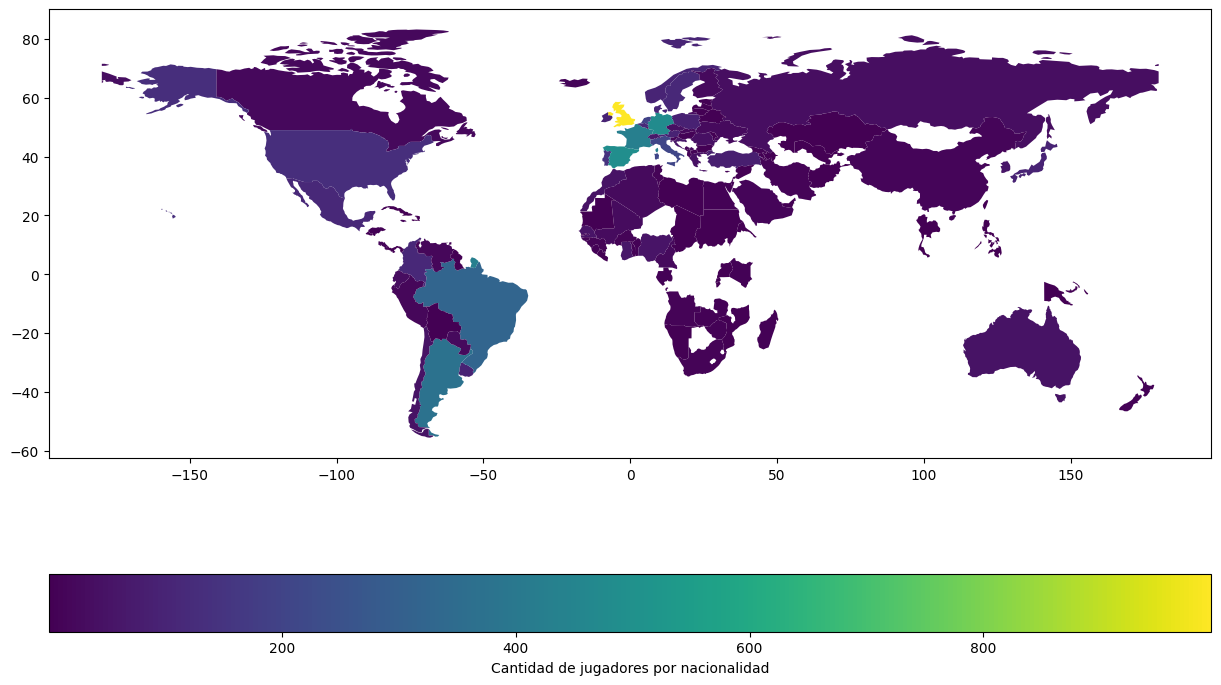

In [7]:
#Grafico que estudia el número de jugadores por país

#Se importa la libreria para realizar los gráficos
import matplotlib.pyplot as plt

#Se hace un recuento de jugadores en función del país
player_counts_by_nationality = data["Nationality"].value_counts().reset_index()
player_counts_by_nationality.columns = ["nationality", "count"]

#Se carga un dataframe con la forma de los paises
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

#Se unen los datos
world = world.merge(player_counts_by_nationality, how="left", left_on="name", right_on="nationality")

#Se crea un mapa de calor que muestre la cantidad de jugadores en función del país
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.plot(column="count", ax=ax, legend=True,
           legend_kwds={"label": "Cantidad de jugadores por nacionalidad",
                        "orientation": "horizontal"})

#Se muestra el mapa
plt.show()


In [8]:
#Se cuenta el número de registros por nacionalidad
country_counts = data["Nationality"].value_counts()

#Se recoge el top 10
top_10_countries = country_counts.head(10)

#Se transforma a un df
top_10_countries_df = top_10_countries.reset_index()
top_10_countries_df.columns = ["PAÍS", "# JUGADORES"]

#Y se muestra
print(top_10_countries_df)


                       PAÍS  # JUGADORES
0            United Kingdom          995
1                     Spain          488
2                   Germany          475
3                    France          425
4                 Argentina          376
5                    Brazil          322
6                     Italy          210
7               Netherlands          197
8                  Portugal          142
9  United States of America          131


In [9]:

#Se cuenta el número de registros por posicion
position_counts = data["Def_POSITION"].value_counts()

#Se muestra
print(position_counts)


Def_POSITION
MEDIOCENTRO    2556
DEFENSA        2147
DELANTERO      1319
PORTERO         487
Name: count, dtype: int64


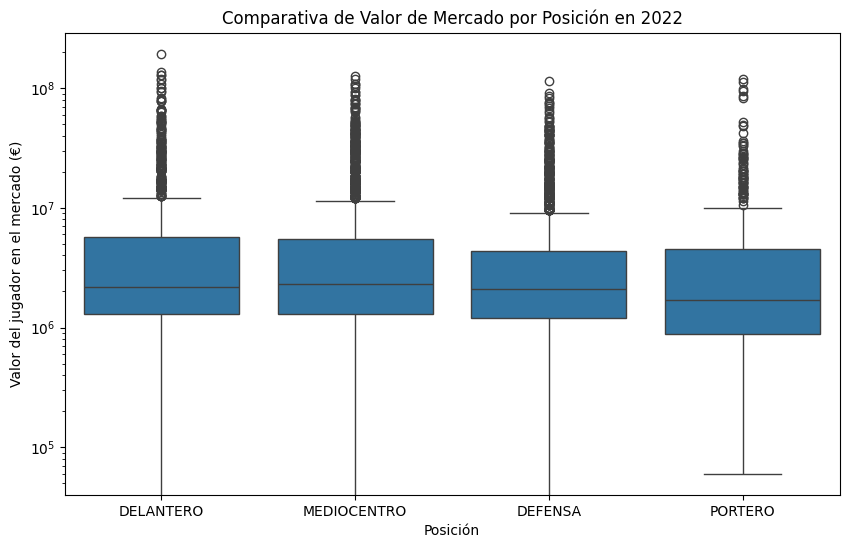

In [10]:
#Grafico que estudia la variable posición en función del valor del jugador en el mercado

#Se carga una nueva liberia para hacer gráficos
import seaborn as sns

#SE cargan de nuevo los datos
data_grafico = data.copy()

#Se transforma la variable value para quitar los caracteres y que este todo en las mismas medidas
def convert_value_to_int(value_str):
    if "M" in value_str:
        return float(value_str.replace("€", "").replace("M", "")) * 1e6
    elif "K" in value_str:
        return float(value_str.replace("€", "").replace("K", "")) * 1e3
    else:
        return float(value_str.replace("€", ""))

#Se aplica la función
data_grafico["Value_2022"] = data["Value_2022"].apply(convert_value_to_int)

#Se crea un diagrama de box-plot 
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x="Def_POSITION", y="Value_2022", data=data_grafico)
ax.set_yscale("log")
ax.set_xlabel("Posición")
ax.set_ylabel("Valor del jugador en el mercado (€)")
ax.set_title("Comparativa de Valor de Mercado por Posición en 2022")

#Se muestra
plt.show()


<Figure size 1400x800 with 0 Axes>

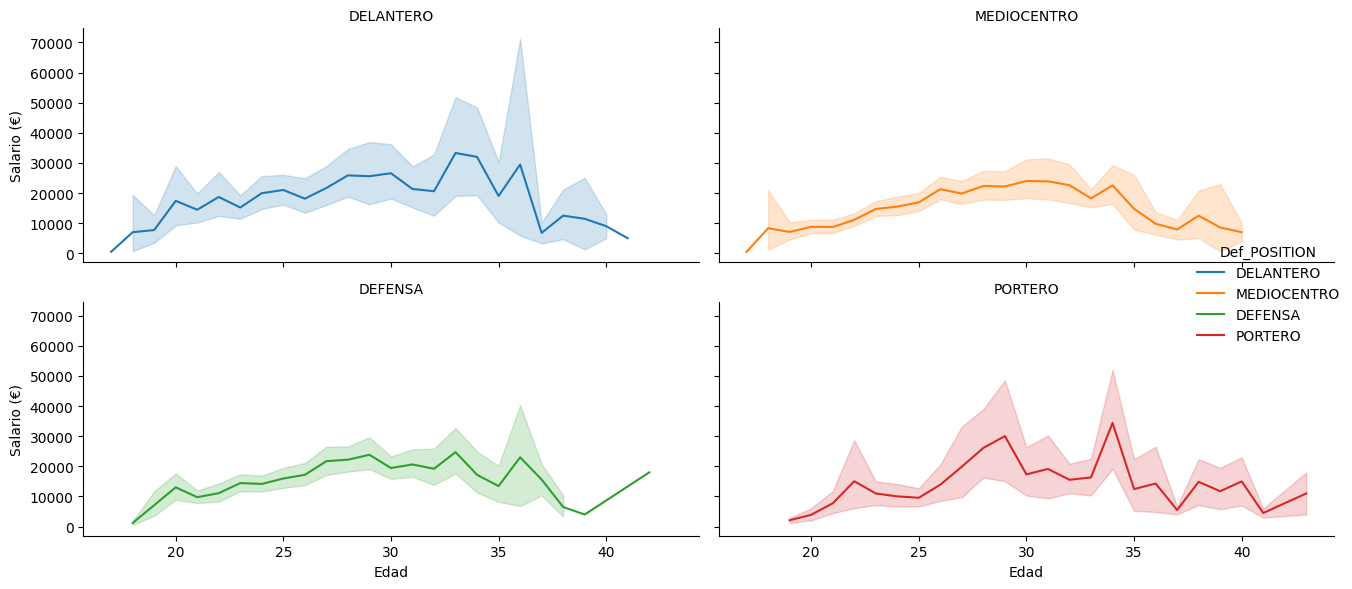

In [11]:
#Grafico que estudia la variable edad en función del salario y de la posición

#Se aplica la función definida en el bloque anterior para el salario
data_grafico["Wage_2022"] = data["Wage_2022"].apply(convert_value_to_int)

#Se crea un gráfico de líneas
plt.figure(figsize=(14, 8))

#Se emplea FacetGrid para tener distintos gráficos en función de la categoría de posición
g = sns.FacetGrid(data_grafico, col="Def_POSITION", hue="Def_POSITION", col_wrap=2, height=3, aspect=2)
g = g.map(sns.lineplot, "Age_2022", "Wage_2022")
g.set_titles("{col_name}")
g.set_axis_labels("Edad", "Salario (€)")
g.add_legend()

#Se muestra
plt.tight_layout()
plt.show()


In [12]:
#Se calculan las mejores habilidades por posicion
from math import pi

#Se carga el conjunto de datos
df = data_grafico

#Se recogen la variables a estudiar
skill_columns = [
    "Finishing_2022", "HeadingAccuracy_2022", "ShortPassing_2022", "Volleys_2022",
    "Dribbling_2022", "Curve_2022", "FKAccuracy_2022", "LongPassing_2022",
    "BallControl_2022", "Acceleration_2022", "SprintSpeed_2022", "Agility_2022",
    "Reactions_2022", "Balance_2022", "ShotPower_2022", "Jumping_2022",
    "Stamina_2022", "Strength_2022", "LongShots_2022", "Interceptions_2022",
    "Vision_2022", "Penalties_2022", "StandingTackle_2022", "SlidingTackle_2022",
    "GKDiving_2022", "GKKicking_2022", "GKPositioning_2022", "GKReflexes_2022"
]

#Nos aseguramos que las vraiables son de tipo númerico
df[skill_columns] = df[skill_columns].apply(pd.to_numeric, errors="coerce")

#Se crea un diccionario vacío para guardar las mejores habilidades por posición
top_skills_per_position = {}

#Se calculan las posiciones únicas
positions = df["Def_POSITION"].unique()

#Se realiza el calculo po cada posicion
for position in positions:
    position_data = df[df["Def_POSITION"] == position]
    #Se calcula la media por cada posicion
    mean_skills = position_data[skill_columns].mean().sort_values(ascending=False).head(5)
    #Se guarda en el diccionario creado anteriormente
    top_skills_per_position[position] = mean_skills.index.tolist()

#Se muestran las 5 habilidades principales por posición
for position, skills in top_skills_per_position.items():
    print(f"Las 5 habilidades más importantes para {position} son: {skills}")



Las 5 habilidades más importantes para DELANTERO son: ['SprintSpeed_2022', 'Acceleration_2022', 'Agility_2022', 'ShotPower_2022', 'BallControl_2022']
Las 5 habilidades más importantes para MEDIOCENTRO son: ['Stamina_2022', 'Agility_2022', 'Balance_2022', 'BallControl_2022', 'Acceleration_2022']
Las 5 habilidades más importantes para DEFENSA son: ['Strength_2022', 'Jumping_2022', 'Stamina_2022', 'StandingTackle_2022', 'SlidingTackle_2022']
Las 5 habilidades más importantes para PORTERO son: ['GKReflexes_2022', 'GKDiving_2022', 'GKPositioning_2022', 'GKKicking_2022', 'Reactions_2022']


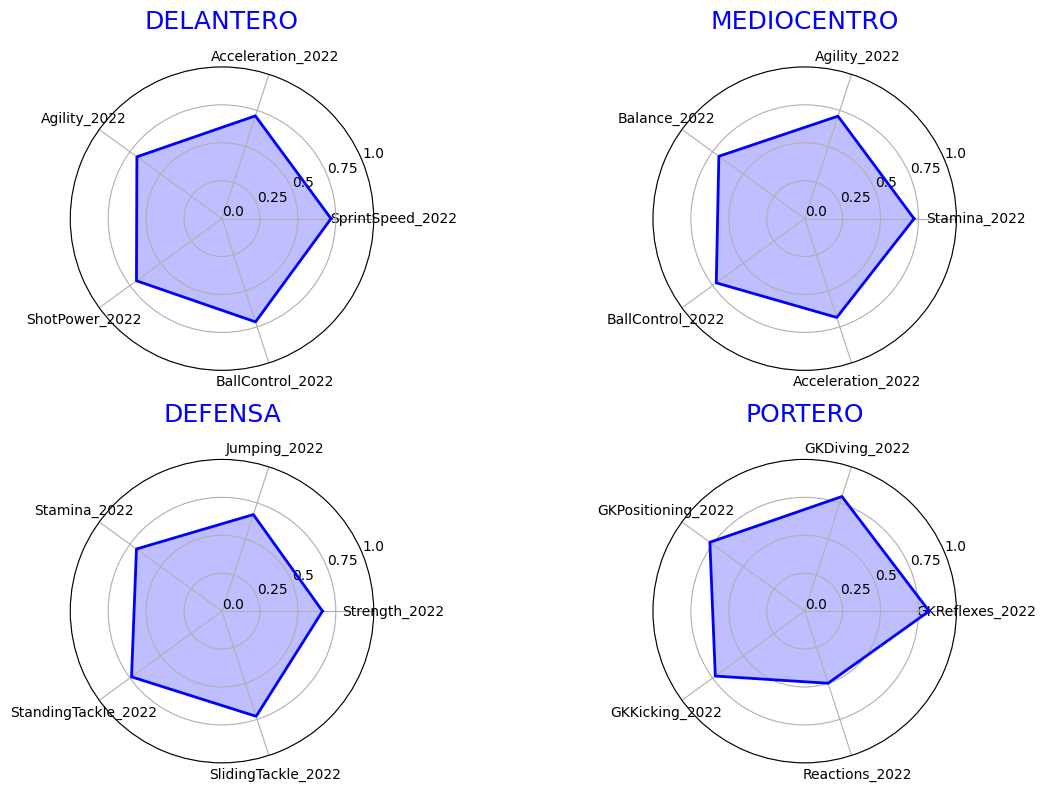

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

#Se convierten las variables a valores númericos
df[skill_columns] = df[skill_columns].apply(pd.to_numeric, errors="coerce")

#Se convierte las variables a valores entre 0 y 1
scaler = MinMaxScaler()
df[skill_columns] = scaler.fit_transform(df[skill_columns])

#Se crea una funcion para crear el gráfico de radar
def create_radar_chart(data, position, skills, fig, axis):
    num_vars = len(skills)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    data += data[:1]  
    angles += angles[:1]  

    ax = fig.add_subplot(axis, polar=True)
    ax.fill(angles, data, color="blue", alpha=0.25)
    ax.plot(angles, data, color="blue", linewidth=2)
    
    #Etiquetas del gráfico
    ax.set_yticks(np.linspace(0, 1, 5))
    ax.set_yticklabels(np.round(np.linspace(0, 1, 5), 2))
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(skills)

    ax.set_title(position, size=18, color="blue", y=1.1)

#Se crea la figura para almacenar el gráfico
fig = plt.figure(figsize=(12, 8))

#Se realiza para cada posición
for i, position in enumerate(top_skills_per_position.keys(), start=1):
    skills = top_skills_per_position[position]
    position_data = df[df["Def_POSITION"] == position]
    data = position_data[skills].mean().tolist()

#Se ejecuta la función
    create_radar_chart(data, position, skills, fig, 220 + i)

#Se muestra
plt.tight_layout()
plt.show()


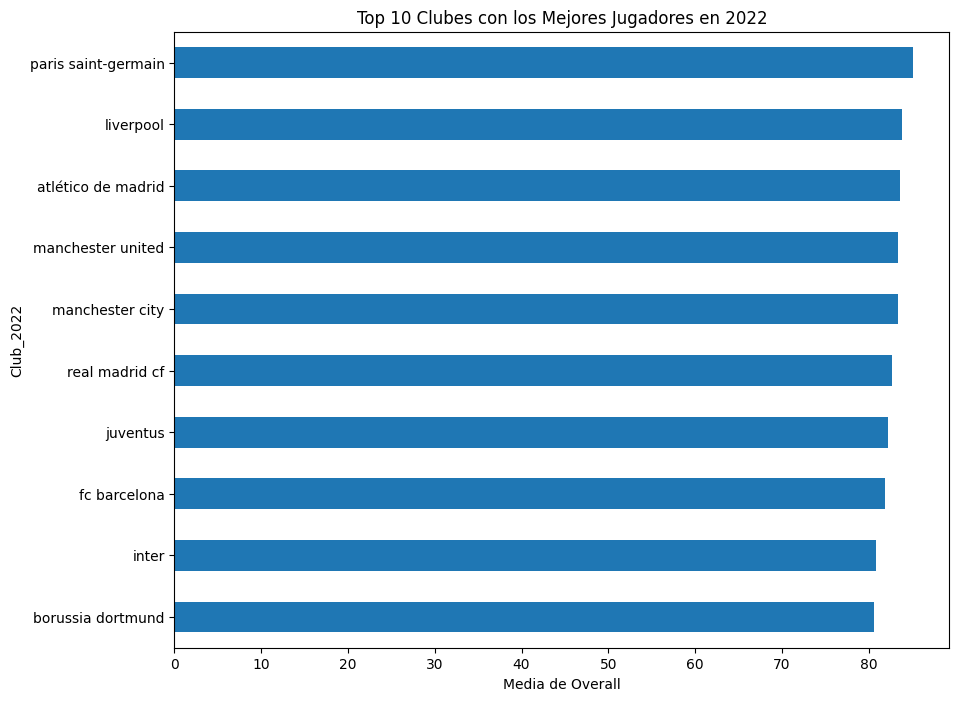

In [14]:
#Grafico de los 10 mejores equipos

#Se calcula la media de la valoracion por cada club
club_overalls = df.groupby("Club_2022")["Overall_2022"].mean()

#Se ordenan las calificaciones y se recogen los top 10
top_clubs = club_overalls.sort_values(ascending=False).head(10)

#Se crea el gráfico de barras
plt.figure(figsize=(10, 8))
top_clubs.plot(kind="barh")
plt.xlabel("Media de Overall")
plt.title("Top 10 Clubes con los Mejores Jugadores en 2022")
plt.gca().invert_yaxis()

#Se muestra
plt.show()


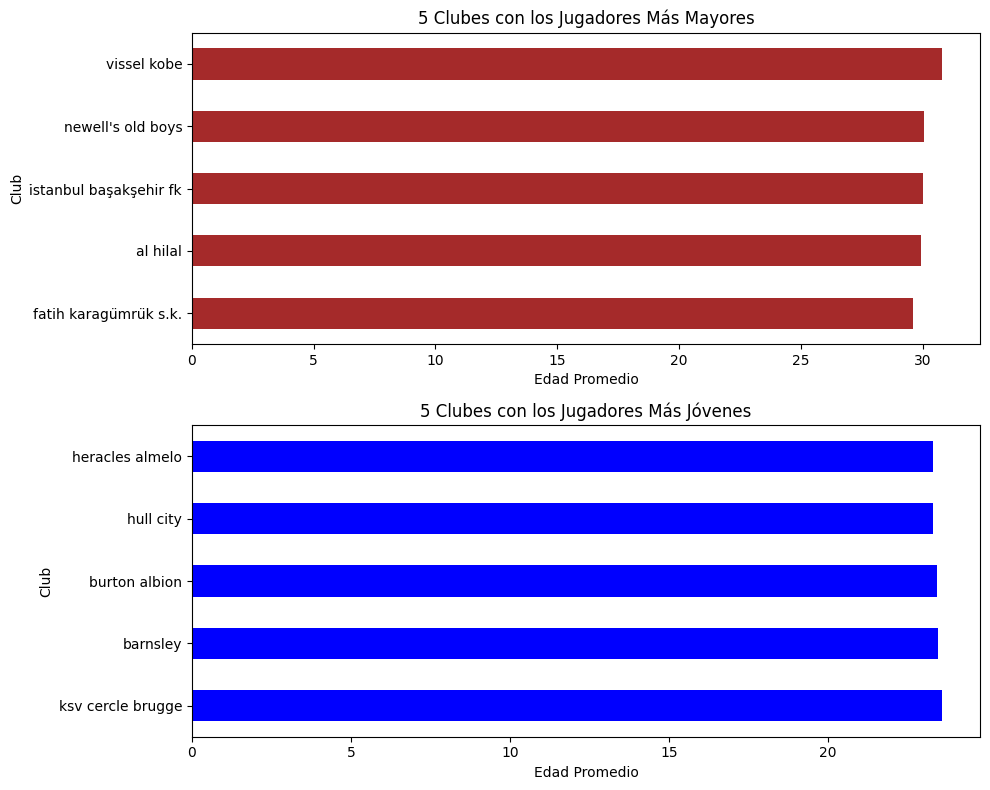

In [15]:
#Grafico con los 5 equipos con mayor edad y los 5 con menor edad


#SE calcula el número de jugadores por equipo
player_counts = df["Club_2022"].value_counts()

#Solo se toma en cuenta los equipos con más de 10 jugadores
clubs_with_enough_players = player_counts[player_counts >= 10].index

#Se filtra el dataset para solo tener en cuenta a estos equipos seleccionados
df_filtered = df[df["Club_2022"].isin(clubs_with_enough_players)]

#SE calcula la edad media por equipo
club_ages = df_filtered.groupby("Club_2022")["Age_2022"].mean()

#SE ordenan y se escogen los 5 más altos y los 5 más bajos
oldest_clubs = club_ages.sort_values(ascending=False).head(5)
youngest_clubs = club_ages.sort_values(ascending=True).head(5)

#Se crean los gráficos
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

#Primero el de la media más alta
oldest_clubs.plot(kind="barh", ax=ax[0], color="brown")
ax[0].set_title("5 Clubes con los Jugadores Más Mayores")
ax[0].set_xlabel("Edad Promedio")
ax[0].invert_yaxis()  # Invertir para que el mayor esté en la parte superior
ax[0].set_ylabel("Club")

#Segundo el de la media más baja
youngest_clubs.plot(kind="barh", ax=ax[1], color="blue")
ax[1].set_title("5 Clubes con los Jugadores Más Jóvenes")
ax[1].invert_yaxis()  # Invertir para que el mayor esté en la parte superior
ax[1].set_xlabel("Edad Promedio")
ax[1].set_ylabel("Club")

#Se muestra
plt.tight_layout()
plt.show()





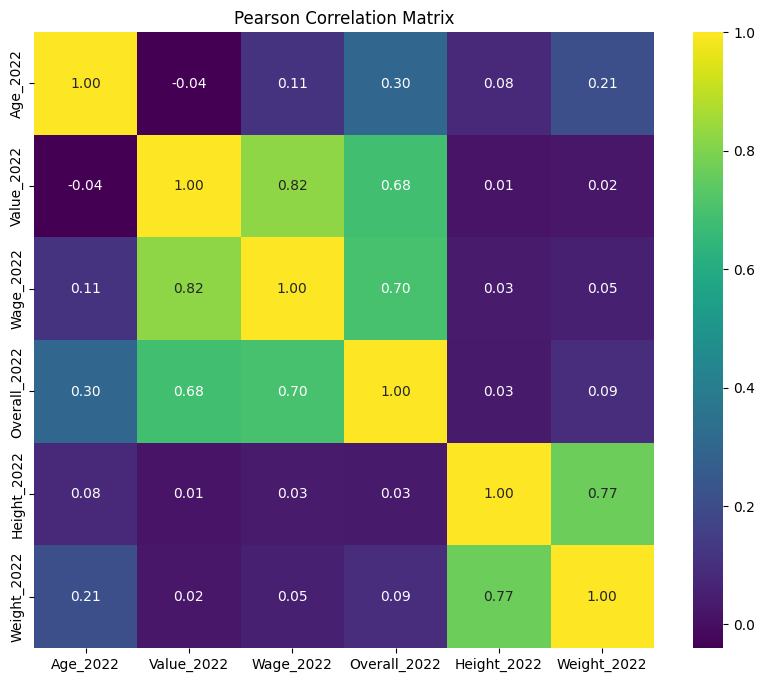

In [16]:
#Gráfico del coeficiente de correlación de Pearson

#Se escogen las varaibles que se usaran en la correlación
cols_for_corr = ["Age_2022", "Value_2022", "Wage_2022", "Overall_2022", "Height_2022", "Weight_2022"]
corr = data_grafico[cols_for_corr].corr(method="pearson")

#Se crea el gráfico
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cbar=True, cmap="viridis")
plt.title("Pearson Correlation Matrix")

#Se muestra
plt.show()

## Algoritmo 1: clustering para encontrar jugadores similares

C:\Users\LENOVO\anaconda3\envs\TFM\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\LENOVO\anaconda3\envs\TFM\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\LENOVO\anaconda3\envs\TFM\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\LENOVO\anaconda3\envs\TFM\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change fr

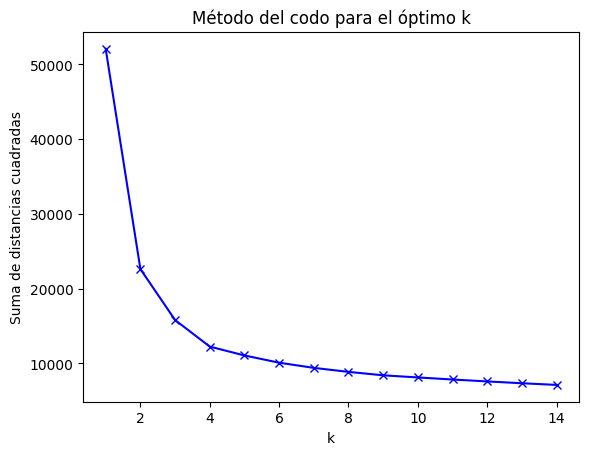

In [17]:
#En primer lugar, fijamos el valor optimo a traves del metodo del codo
import pandas as pd
import unicodedata
import re
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

#Cargamos los datos
df = pd.read_csv(r"https://raw.githubusercontent.com/Sergioferr7/TFM_Sergio_Fernandez_Villafa-ez/main/df_saved.csv")

#Se seleccionan las variables númericas relevantes en el estudio
features = [f"{skill}_2022" for skill in [ "Finishing", "ShortPassing","Dribbling", "Acceleration",  "Stamina","Interceptions","GKDiving", "GKReflexes"]]

#Se normalizan los datos
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[features])

#A traves del método del codo se elige el número de clusters
sum_of_squared_distances = []
K = range(1, 15)  
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_scaled)
    sum_of_squared_distances.append(km.inertia_)

#Se muestra el gráfico
plt.plot(K, sum_of_squared_distances, "bx-")
plt.xlabel("k")
plt.ylabel("Suma de distancias cuadradas")
plt.title("Método del codo para el óptimo k")
plt.show()




C:\Users\LENOVO\anaconda3\envs\TFM\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


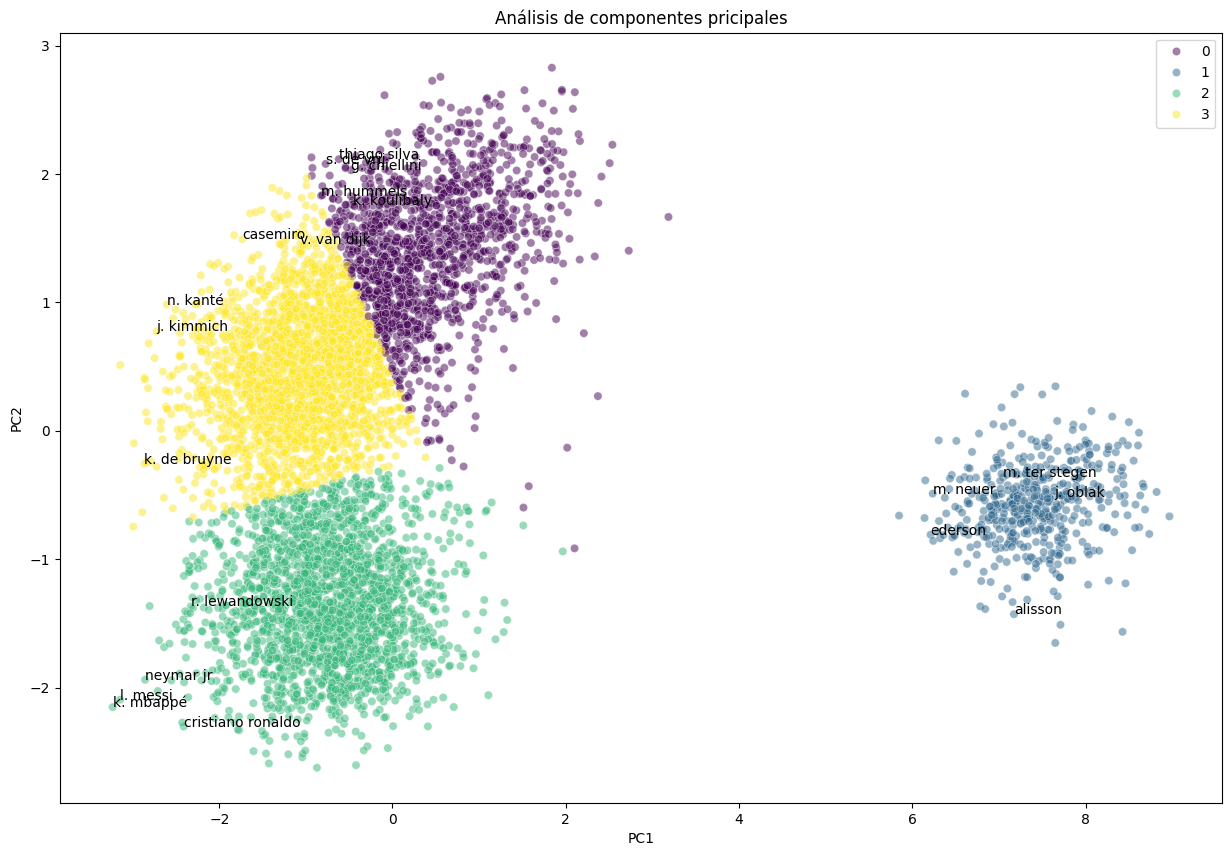

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np


#Se realiza el PCA para reducir a dos dimensiones
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_scaled)

#Se implementa el KMeans de clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(principal_components)

#Se crea un dataframe con las componentes principales calculadas y las etiquetas de cluster
pca_df = pd.DataFrame(data=principal_components, columns=["PC1", "PC2"])
pca_df["Cluster"] = clusters
pca_df["Name"] = df["Name"]  

#Se seleccionan 5 jugadores en cada cluster con un Overall alto
players_to_label = pd.DataFrame()

for cluster in range(4):
    cluster_indices = pca_df[pca_df["Cluster"] == cluster].index
    top_players = df.loc[cluster_indices].nlargest(5, "Overall_2022")
    players_to_label = pd.concat([players_to_label, top_players])

#Se crea el gráfico a mostrar
plt.figure(figsize=(15, 10))
sns.scatterplot(x="PC1", y="PC2", hue="Cluster", data=pca_df, palette="viridis", alpha=0.5)

#Se etiquetan los nombres de los 5 jugadores por cluster
for i, row in players_to_label.iterrows():
    plt.text(pca_df.loc[i, "PC1"], pca_df.loc[i, "PC2"], row["Name"])

#Se muestra el gráfico
plt.title("Análisis de componentes pricipales")
plt.legend()
plt.show()

In [19]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

#Se seleccionan las variables numericas
features = df.select_dtypes(include=[np.number])

#Se escalan los datos
scaler = StandardScaler()
df_scaled = scaler.fit_transform(features)

#Se selecciona el jugador a estudiar
selected_player = input("Por favor, introduzca el nombre del jugador que desea estudiar: (ej. cristiano ronaldo, l. messi)").strip().lower()

#Se selecciona su ID y se filtra por si hay varios con el mismo nombre por el jugador con mayor puntuación
player_row = df[df["Name"] == selected_player].nlargest(1, "Overall_2022")

#Se verifica que el nombre es correcto
if player_row.empty:
    print("Escribió un nombre erróneo, revise su ortografía y recuerde ponerlo todo en minúsculas")
else:
    
    player_index = player_row.index[0]
    
    #Se calcula la similitud
    cosine_similarities = cosine_similarity(df_scaled, df_scaled[player_index:player_index+1])
    
    #Se crea un dataframe
    similarity_df = pd.DataFrame(cosine_similarities, index=df.index, columns=["Similarity"])
    
    #Se añade la similitud calculada al dataframe
    df["Similarity"] = similarity_df["Similarity"]
    
    #Se ordenan los jugadores por similitud y se excluye al jugador seleccionado
    sorted_similarities = df.loc[df["Name"] != selected_player, :].sort_values(by="Similarity", ascending=False)
    
    #Se coge el top 5 más similar
    top_5_similar = sorted_similarities.head(5)
    
    #Se muestra
    print(top_5_similar[["ID", "Name", "Similarity"]])


Por favor, introduzca el nombre del jugador que desea estudiar: (ej. cristiano ronaldo, l. messi) cristiano ronaldo


         ID           Name  Similarity
281  188567  p. aubameyang    0.929595
194  165153     k. benzema    0.927128
132  153079     s. agüero    0.918943
18   173731        g. bale    0.904301
230  193301   a. lacazette    0.893994


In [20]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

df = pd.read_csv(r'https://raw.githubusercontent.com/Sergioferr7/TFM_Sergio_Fernandez_Villafa-ez/main/df_saved.csv')

#Se seleccionan las variables numericas
features = df.select_dtypes(include=[np.number])

#Se escalan los datos
scaler = StandardScaler()
df_scaled = scaler.fit_transform(features)

#Se selecciona el jugador a estudiar
selected_player_name = input("Por favor, introduzca el nombre del jugador que desea estudiar:(ej. cristiano ronaldo, l. messi) ").strip().lower()

#Se selecciona su ID y se filtra por si hay varios con el mismo nombre por el jugador con mayor puntuación
player_df = df[df['Name'] == selected_player_name].nlargest(1, 'Overall_2022')

#Se verifica que el nombre es correcto
if player_df.empty:
    print("Escribió un nombre erróneo, revise su ortografía y recuerde ponerlo todo en minúsculas")
else:

    #Se calcula la similitud
    selected_player_id = player_df['ID'].iloc[0]
    player_index = df.index[df['ID'] == selected_player_id].tolist() 
    cosine_similarities = cosine_similarity(df_scaled, df_scaled[player_index])
    
    #Se añade la similitud calculada al dataframe
    df['Similarity'] = cosine_similarities
    
    #Se coge el top 5 más similar 
    top_5_similar = df[df['ID'] != selected_player_id].nlargest(5, 'Similarity')
    
    #Se definen las variables que s emostraran de los jugadores
    additional_columns = ["ID", "Name","Age_2022", "Nationality", "Club_2022", "Value_2022",
                          "Overall_2022", "Preferred Foot", "Contract Valid Until_2022",
                          'Finishing_2022', 'ShortPassing_2022', 'Dribbling_2022',
                          'Acceleration_2022', 'Stamina_2022', 'Interceptions_2022',
                          'GKDiving_2022', 'GKReflexes_2022', 'Similarity']
    
    # Añade la fila del jugador seleccionado al principio del DataFrame top_5_similar
    selected_player_row = df[df['ID'] == selected_player_id][additional_columns]
    selected_player_row['Similarity'] = 1.0  #La similitud de un jugador con él mismo es 1
    top_players = pd.concat([selected_player_row, top_5_similar[additional_columns]])
    
    #Se modifica el formato de la columna Value y de las habilidades
    def format_value(value):
        #Función para formatear la columna "Value_2022" en el formato deseado
        return f'{value:.0f} €' if pd.notnull(value) else None
    
    def format_skill(skill):
        #Función para formatear las columnas de habilidades
        return f'{skill:.0f}' if pd.notnull(skill) else None
    
    #Se aplican los formatos
    top_players['Value_2022'] = top_players['Value_2022'].apply(format_value)
    skill_columns = ['Finishing_2022', 'ShortPassing_2022', 'Dribbling_2022', 
                     'Acceleration_2022', 'Stamina_2022', 'Interceptions_2022', 
                     'GKDiving_2022', 'GKReflexes_2022','Contract Valid Until_2022']
    for column in skill_columns:
        top_players[column] = top_players[column].apply(format_skill)
    
    #Se elimina ID
    top_players_final = top_players.drop(columns='ID')
    
    #Se renombra las columnas quitando el sufijo '_2022'
    rename_columns = {
        "Club_2022": "Club",
        "Age_2022": "Age",
        "Value_2022": "Value",
        "Overall_2022": "Overall",
        "Contract Valid Until_2022": "Contract Valid Until",
        "Finishing_2022": "Finishing",
        "ShortPassing_2022": "ShortPassing",
        "Dribbling_2022": "Dribbling",
        "Acceleration_2022": "Acceleration",
        "Stamina_2022": "Stamina",
        "Interceptions_2022": "Interceptions",
        "GKDiving_2022": "GKDiving",
        "GKReflexes_2022": "GKReflexes"
    }
    
    #Se aplica
    top_players_final = top_players_final.rename(columns=rename_columns)

    # Suponiendo que 'top_players_final' es tu DataFrame final.
    top_players_final.reset_index(drop=True, inplace=True)
    
    #Se muestra
    print(top_players_final.to_string(index=False))


Por favor, introduzca el nombre del jugador que desea estudiar:(ej. cristiano ronaldo, l. messi)  cristiano ronaldo


             Name  Age    Nationality              Club      Value  Overall Preferred Foot Contract Valid Until Finishing ShortPassing Dribbling Acceleration Stamina Interceptions GKDiving GKReflexes  Similarity
cristiano ronaldo   36       Portugal manchester united 45000000 €       91          right                 2023        95           80        88           85      77            29        7         11    1.000000
    p. aubameyang   32          Gabon           arsenal 43500000 €       85          right                 2023        89           77        79           87      79            48        6          9    0.929595
       k. benzema   33         France    real madrid cf 66000000 €       89          right                 2023        90           86        87           77      78            39       13          7    0.927128
       s. agüero   33      Argentina      fc barcelona 51000000 €       87          right                 2023        93           80        86        

In [21]:
#Se crea una tabla con los resultados anteriores
styled_table = top_players_final.style.set_table_styles([
    {"selector": "th", "props": [("font-size", "11pt"), ("text-align", "center"), ("background-color", "#f4f4f4"), ("color", "black")]},
    {"selector": "td", "props": [("text-align", "center")]},
    {"selector": "tr:nth-of-type(odd)", "props": [("background-color", "#eee")]},
    {"selector": "tr:nth-of-type(even)", "props": [("background-color", "white")]},
    {"selector": "tr:hover", "props": [("background-color", "#ffff99")]}
]).set_properties(**{"border-color": "black", "border-style": "solid", "border-width": "1px"})

#Se muestra la tabla
styled_table



,Name,Age,Nationality,Club,Value,Overall,Preferred Foot,Contract Valid Until,Finishing,ShortPassing,Dribbling,Acceleration,Stamina,Interceptions,GKDiving,GKReflexes,Similarity
0,cristiano ronaldo,36,Portugal,manchester united,45000000 €,91,right,2023,95,80,88,85,77,29,7,11,1.000000
1,p. aubameyang,32,Gabon,arsenal,43500000 €,85,right,2023,89,77,79,87,79,48,6,9,0.929595
2,k. benzema,33,France,real madrid cf,66000000 €,89,right,2023,90,86,87,77,78,39,13,7,0.927128
3,s. agüero,33,Argentina,fc barcelona,51000000 €,87,right,2023,93,80,86,75,62,24,13,14,0.918943
4,g. bale,31,United Kingdom,real madrid cf,25000000 €,82,left,2022,82,80,80,80,61,53,15,6,0.904301
5,a. lacazette,30,France,arsenal,30000000 €,82,right,2022,83,79,83,77,66,42,11,6,0.893994


In [22]:
#Se guarda en un dataframe
df_to_save = top_players_final

#Se define la ruta
#excel_file_path = r"C:\Users\LENOVO\Desktop\UNIR_MASTER\TFM\top_players_final.xlsx"

#Se guarda la tabla en un excel
#df_to_save.to_excel(excel_file_path, index=False)

#Se muestra la ruta donde se ha guardado
#print(f"Descarga tu archivo Excel desde: {excel_file_path}")


## Algoritmo 2: prediccion de la nota de un jugador al año siguiente

### Regresión lineal

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

#Cargamos los datos
df = pd.read_csv(r"https://raw.githubusercontent.com/Sergioferr7/TFM_Sergio_Fernandez_Villafa-ez/main/df_saved.csv")

#Se definen las habilidades sobre las que se ejecutara el algoritmo 2
features = ["Finishing", "ShortPassing", "Dribbling", "Acceleration", "Stamina", "Interceptions", "GKDiving", "GKReflexes","Overall"]


#Se definen X e y
X = df[[f"{feature}_{year}" for year in range(2020, 2023) for feature in features]]
y = df["Overall_2022"]

#Se divide un 20% para test y un 80% para validación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Se define el nombre del jugador a predecir
player_name = input("Por favor, introduzca el nombre del jugador que desea estudiar:(ej. cristiano ronaldo, l. messi) ").strip().lower()

#Se crea un DataFrame que contiene las estadísticas de un jugador en 2020, 2021 y 2022
player_data = df[df["Name"].str.lower() == player_name.lower()][[f"{feature}_{year}" for year in range(2020, 2023) for feature in features]]


#Se verifica que el nombre es correcto
if player_data.empty:
    print("Escribió un nombre erróneo, revise su ortografía y recuerde ponerlo todo en minúsculas")
else:

    #Se crea y entrena en modelo de regresión lineal en este caso
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    #Se implementa en el modelo de prueba y el final
    y_pred = model.predict(X_test)
    predicted_overall_2023 = model.predict(player_data)
    
    #Se calcula el error cuadrático medio (RMSE)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    
    #Se almacena el Overall de los años anteriores
    overall_2020 = player_data["Overall_2020"].iloc[0]
    overall_2021 = player_data["Overall_2021"].iloc[0]
    overall_2022 = player_data["Overall_2022"].iloc[0]
    
    #Se muestran los resultados los resultados
    print(f"Error Cuadrático Medio (RMSE): {rmse}")
    print(f"Error Absoluto Medio (MAE): {mae}")
    print(f"Coeficiente de Determinación (R^2): {r2}")
    print(f"Jugador estudiado: {player_name}")
    print(f"Overall en 2020: {overall_2020}")
    print(f"Overall en 2021: {overall_2021}")
    print(f"Overall en 2022: {overall_2022}")
    print(f"Predicción de Overall para el año 2023: {predicted_overall_2023[0]}")



Por favor, introduzca el nombre del jugador que desea estudiar:(ej. cristiano ronaldo, l. messi)  cristiano ronaldo


Error Cuadrático Medio (RMSE): 6.764344464811488e-15
Error Absoluto Medio (MAE): 3.3180490272053835e-15
Coeficiente de Determinación (R^2): 1.0
Jugador estudiado: cristiano ronaldo
Overall en 2020: 93
Overall en 2021: 92
Overall en 2022: 91
Predicción de Overall para el año 2023: 90.99999999999999


### Arboles de decisión

In [24]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#Cargamos los datos
df = pd.read_csv(r"https://raw.githubusercontent.com/Sergioferr7/TFM_Sergio_Fernandez_Villafa-ez/main/df_saved.csv")

#Se definen las habilidades sobre las que se ejecutara el algoritmo 2
features = ["Finishing", "ShortPassing", "Dribbling", "Acceleration", "Stamina", "Interceptions", "GKDiving", "GKReflexes"]

# Se generan los nombres de columnas para múltiples años
feature_columns = [f"{feature}_{year}" for year in range(2020, 2023) for feature in features]

#Se definen X e y
X = df[feature_columns]
y = df["Overall_2022"]

#Se divide en un 20% para test y un 80% para entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Se define el nombre del jugador a predecir, se suprimen espacios y cuentas mayusculas
player_name = input("Por favor, introduzca el nombre del jugador que desea estudiar:(ej. cristiano ronaldo, sergio ramos) ").strip().lower()
player_data = df[df["Name"].str.lower() == player_name.lower()]

#Se verifica que el nombre es correcto
if player_data.empty:
    print("Escribió un nombre erróneo, revise su ortografía y recuerde ponerlo todo en minúsculas")
else:
    player_features = player_data[feature_columns].iloc[0]
    
    #Se crea y entrena en modelo de árboles de decisión en este caso
    dt = DecisionTreeRegressor(random_state=42, max_depth=10, min_samples_split=10, min_samples_leaf=5)
    dt.fit(X_train, y_train)

    # Antes de la predicción:
    player_features_df = pd.DataFrame([player_features.values], columns=feature_columns)

    #Se implementa en el modelo de prueba y el final
    y_pred = dt.predict(X_test)
    predicted_overall_2023 = dt.predict(player_features_df)

   #Se calculan las métricas para medir el error
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    #Se almacena el Overall de los años anteriores
    overall_2020 = player_data["Overall_2020"].iloc[0]
    overall_2021 = player_data["Overall_2021"].iloc[0]
    overall_2022 = player_data["Overall_2022"].iloc[0]

    #Se muestran los resultados los resultados
    print(f"Error Cuadrático Medio (RMSE): {rmse}")
    print(f"Error Absoluto Medio (MAE): {mae}")
    print(f"Coeficiente de Determinación (R^2): {r2}")
    print(f"Jugador estudiado: {player_name}")
    print(f"Overall en 2020: {overall_2020}")
    print(f"Overall en 2021: {overall_2021}")
    print(f"Overall en 2022: {overall_2022}")
    print(f"Predicción de Overall para el año 2023: {predicted_overall_2023[0]}")


Por favor, introduzca el nombre del jugador que desea estudiar:(ej. cristiano ronaldo, sergio ramos)  cristiano ronaldo


Error Cuadrático Medio (RMSE): 2.152166378233311
Error Absoluto Medio (MAE): 1.6717981078432094
Coeficiente de Determinación (R^2): 0.8493820533053573
Jugador estudiado: cristiano ronaldo
Overall en 2020: 93
Overall en 2021: 92
Overall en 2022: 91
Predicción de Overall para el año 2023: 90.375


### Bosques aleatorios o Random Forest

In [25]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#Cargamos los datos
df = pd.read_csv(r"https://raw.githubusercontent.com/Sergioferr7/TFM_Sergio_Fernandez_Villafa-ez/main/df_saved.csv")

#Se definen las habilidades sobre las que se ejecutara el algoritmo 2
features = ["Finishing", "ShortPassing", "Dribbling", "Acceleration", "Stamina", "Interceptions", "GKDiving", "GKReflexes"]

# Se generan los nombres de columnas para múltiples años
feature_columns = [f"{feature}_{year}" for year in range(2020, 2023) for feature in features]

#Se definen X e y
X = df[feature_columns]
y = df["Overall_2022"]

#Se divide en un 20% para test y un 80% para entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Se define el nombre del jugador a predecir y se suprimen espacios y letras mayusculas
player_name = input("Por favor, introduzca el nombre del jugador que desea estudiar:(ej. cristiano ronaldo, sergio ramos) ").strip().lower()
player_data = df[df["Name"].str.lower() == player_name.lower()]

# Verificar si se encontraron datos
if player_data.empty:
    print("Escribió un nombre erróneo, revise su ortografía y recuerde ponerlo todo en minúsculas")
else:
    
    #Se crea y entrena en modelo de random forest en este caso
    rf = RandomForestRegressor(random_state=42)
    
    #Se crea y entrena en modelo de random forest en este caso
    param_grid = {
        "n_estimators": [100, 200],
        "max_depth": [10, 20, None],
    }
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring="neg_mean_squared_error", n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    #se escoge la mejor opción
    best_rf = grid_search.best_estimator_
    
    #Se implementa en el modelo de prueba
    y_pred = best_rf.predict(X_test)

    #Se crea un DataFrame que contiene las estadísticas de un jugador en 2020, 2021 y 2022
    player_features = player_data[feature_columns].iloc[0]
    
    # Antes de la predicción:
    player_features_df = pd.DataFrame([player_features.values], columns=feature_columns)

    #Prediccion
    predicted_overall_2023 = best_rf.predict(player_features_df)
    
    #Se calculan las métricas para medir el error
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    #Se almacena el Overall de los años anteriores
    overall_2020 = player_data["Overall_2020"].iloc[0]
    overall_2021 = player_data["Overall_2021"].iloc[0]
    overall_2022 = player_data["Overall_2022"].iloc[0]

    #Se muestran los resultados
    print(f"Error Cuadrático Medio (RMSE): {rmse}")
    print(f"Error Absoluto Medio (MAE): {mae}")
    print(f"Coeficiente de Determinación (R^2): {r2}")
    print(f"Jugador estudiado: {player_name}")
    print(f"Overall en 2020: {overall_2020}")
    print(f"Overall en 2021: {overall_2021}")
    print(f"Overall en 2022: {overall_2022}")
    print(f"Predicción de Overall para el año 2023: {predicted_overall_2023[0]}")


Por favor, introduzca el nombre del jugador que desea estudiar:(ej. cristiano ronaldo, sergio ramos)  cristiano ronaldo


Error Cuadrático Medio (RMSE): 1.6424301463728326
Error Absoluto Medio (MAE): 1.2583141321044546
Coeficiente de Determinación (R^2): 0.912279953447179
Jugador estudiado: cristiano ronaldo
Overall en 2020: 93
Overall en 2021: 92
Overall en 2022: 91
Predicción de Overall para el año 2023: 89.58


## Algoritmo 3: seleccion del mejor jugador en base a unas características determinadas

In [26]:
import pandas as pd
from tabulate import tabulate

#Cargamos los datos
df = pd.read_csv(r"https://raw.githubusercontent.com/Sergioferr7/TFM_Sergio_Fernandez_Villafa-ez/main/df_saved.csv")

#Se normalizan las variables input
df["Club_2022"] = df["Club_2022"].str.strip().str.lower()
df["Def_POSITION"] = df["Def_POSITION"].str.strip().str.lower()

#Se solicita al usuario los valores de entrada
team_name = input("Por favor, introduzca el nombre del equipo:(ej. real madrid cf, fc barcelona) ").strip().lower()
position = input("Por favor, introduzca la posición a estudiar (ej. delantero, mediocampista, etc.): ").strip().lower()

#Se realiza el filtrado por lo valores introducidos por el usuario
filtered_df = df[(df["Club_2022"] == team_name) & (df["Def_POSITION"] == position)]

#Se comprueba si lo datos introducidos son correctos
if filtered_df.empty:
    print("No se encontraron jugadores que coincidan con los criterios especificados.")
else:
    #Se filtra por el jugador con mayor puntuación
    max_overall = filtered_df["Overall_2022"].max()
    
    #Si hay más de uno con la misma puntuación lo recogemos
    best_players = filtered_df[filtered_df["Overall_2022"] == max_overall]

    #Se crea la tabla con la salida
    table = best_players[["Name", "Overall_2022", "Age_2022", "Preferred Foot"]].rename(columns={
        "Name": "Nombre",
        "Overall_2022": "Puntuación",
        "Age_2022": "Edad",
        "Preferred Foot": "Pie Preferido"
    })

    #Se muestra la tabla creada
    print(f"Mejores jugadores en la posición de {position} para el equipo {team_name} en 2022:")
    print(tabulate(table, headers="keys", tablefmt="pretty", showindex=False))


Por favor, introduzca el nombre del equipo:(ej. real madrid cf, fc barcelona)  real madrid cf
Por favor, introduzca la posición a estudiar (ej. delantero, mediocampista, etc.):  delantero


Mejores jugadores en la posición de delantero para el equipo real madrid cf en 2022:
+------------+------------+------+---------------+
|   Nombre   | Puntuación | Edad | Pie Preferido |
+------------+------------+------+---------------+
| k. benzema |     89     |  33  |     right     |
+------------+------------+------+---------------+
